# Comparing to N-body integrations

To facilitate comparison to N-body integrations, we have made a simple `NbodyRegressor` wrapper class, which simply initializes a `REBOUND` N-body integration. It uses the same parameters and interface as our `FeatureClassifier`.

Let's set up the same Simulation as in the Quickstart example:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


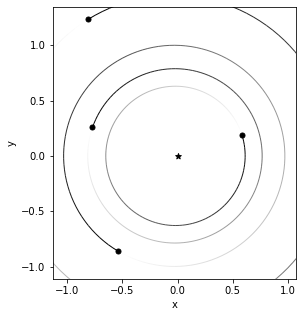

In [1]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-4, P=3.14, e=0.03, l=0.3)
sim.add(m=1.e-4, P=4.396, e=0.03, l=2.8)
sim.add(m=1.e-4, P=6.28, e=0.03, l=4.2)
sim.add(m=1.e-4, P=10.99, e=0.03, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

The interface is the same:

We begin by making instances of the models we want to compare:

In [2]:
from spock import FeatureClassifier
fmodel = FeatureClassifier()

from spock import NbodyRegressor
nbody = NbodyRegressor()

from spock import DeepRegressor
dmodel = DeepRegressor()

# Binary Classification of Stability

The interface is the same. By default, all our models evaluate stability over $10^9$ orbits of the innermost planet. We can use our feature-based model SPOCK

In [3]:
%%time
fmodel.predict_stable(sim)

CPU times: user 537 ms, sys: 3.07 ms, total: 540 ms
Wall time: 538 ms


0.0061098333

Or our deep model (takes a bit longer to evaluate)

In [4]:
%%time
dmodel.predict_stable(sim)

CPU times: user 25 s, sys: 45.4 s, total: 1min 10s
Wall time: 17.7 s


0.002

Or direct Nbody:

In [5]:
%%time
nbody.predict_stable(sim)

CPU times: user 1.25 s, sys: 1.64 ms, total: 1.26 s
Wall time: 1.26 s


0

nbody returns a simple stable (1) or unstable (0), while our other models return an estimated probability of stability (unless it goes unstable within the first $10^4$ orbits used for the short N-body integration to generate features, in which case it returns exactly zero). We see both the FeatureClassifier and DeepClassifier return sensible estimates.

Note that the nbody cell above does not take long because the system only took about 60,000 orbits of the innermost planet to go unstable (see below how to get actual instability times).

By default, these functions will integrate for a billion orbits of the planet with the shortest orbital period (the same threshold used by the FeatureClassifier). So if you set up a stable system, these will take several hours to evaluate with Nbody! The other model evaluations will remain just as fast.

You can also set a different maximum integration time (in simulation time units). Let's ask whether the system is stable over the first 10,000 orbits of the innermost planet:

In [6]:
nbody.predict_stable(sim, tmax=1e4*sim.particles[1].P)

1

Note that the above prediction is no longer a one-to-one comparison with our `FeatureClassifier`, which has been trained on a dataset integrated for a billion orbits of the innermost planet. 

Because our `DeepRegressor` goes beyond simply classifying stability over $10^9$ orbits to predicting instability times, it can evaluate stability over other timescales like Nbody:

In [7]:
dmodel.predict_stable(sim, tmax=1e4*sim.particles[1].P)

0.603

# Predicting Instability Times

It looks like the DeepRegressor might have been a bit off on the case above, but this is likely a reasonable estimate. Because these compact systems are chaotic, there isn't a single instability time for a given configuration. Instead, different equally valid chaotic realizations of that initial configuration's trajectory will yield a distribution of instability times. Since Nbody integrations are typically too expensive to run several realizations, we provide approximate error bars on Nbody instability times as estimated in [Hussain & Tamayo 2020](https://arxiv.org/abs/2001.04606) 

In [8]:
t_inst, lower, upper = nbody.predict_instability_time(sim) # instability time in time units used when setting up the Simulation
print('Went unstable after {0:.1f} orbits of the inner planet. 68% confidence interval = [{1:.0f}, {2:.0f}] orbits.'.format(t_inst/sim.particles[1].P, lower/sim.particles[1].P, upper/sim.particles[1].P))

Went unstable after 60661.3 orbits of the inner planet. 68% confidence interval = [14955, 246050] orbits.


The `DeepRegressor` has the same interface. In this case the error bars correspond to the model's uncertainty including both the above unceratinty due to the chaos, and the uncertainties on the models' internal parameters (see paper).

In [9]:
t_inst, lower, upper = dmodel.predict_instability_time(sim) # instability time in time units used when setting up the Simulation
print('Estimated instability time: {0:.1f} orbits of the inner planet. 68% confidence interval = [{1:.0f}, {2:.0f}] orbits.'.format(t_inst/sim.particles[1].P, lower/sim.particles[1].P, upper/sim.particles[1].P))

Estimated instability time: 17325.8 orbits of the inner planet. 68% confidence interval = [5095, 132323] orbits.


Note that even a perfect model would only be able to provide estimates approximately within the uncertainties returned by `NbodyRegressor`.

If `predict_instability_time` reaches tmax, it will just return tmax as the "instability time":

In [10]:
t_inst, lower, upper = nbody.predict_instability_time(sim, tmax=1e4*sim.particles[1].P)
print(t_inst)

31400.00000000001


Note that this can look like an arbitrary number! It's a good idea to check whether it's a real instability time, or whether you've just hit tmax. If you've hit tmax, the lower and upper confidence intervals will both be set to zero

In [11]:
print(t_inst/sim.particles[1].P)

10000.0


In [12]:
print(lower, upper)

0 0


# Parallelization

All models can also take a list of Simulations, in which case you get back a list of results. By default, the model will use all available cores. You can set a smaller number of cores with `n_jobs`

In [18]:
def sim(mass):
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=mass, P=1.)
    sim.add(m=mass, P=1.3)
    sim.add(m=mass, P=1.6)
    return sim

sims = [sim(mass) for mass in [1e-4, 3e-4, 1e-3]]

In [19]:
nbody.predict_stable(sims)

AttributeError: 'list' object has no attribute 'particles'

# Simulation Archives

Because the N-body integrations can take several hours of computation time, we provide an option to save `SimulationArchives`, binary snapshots which you can later examine or reload to run further. These make it easy to reproducibly share N-body integrations (see Rein & Tamayo 2017).

You specify the filename (and path), and the time between snapshots (in Simulation time units). The latter defaults to a value that will give you 1000 snapshots if the integration remains stable the entire time. This way archives don't take up too much space, but here we hardcode a short interval since the system has a short survival time. 1000 snapshots corresponds to a few MB.

__Note that this function will overwrite if the same filename already exists.__

In [9]:
nbody.predict_instability_time(sim, archive_filename='test.bin', archive_interval=1e2)

90806.15665630097

We can now reopen and inspect for example the eccentricities of the second planet at each snapshot. 

Text(0, 0.5, 'Planet 2 Eccentricity')

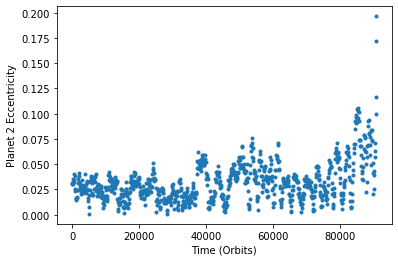

In [10]:
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

sa = rebound.SimulationArchive('test.bin')
times, e = [], []
for sim in sa:
    times.append(sim.t)
    e.append(sim.particles[2].e)
    
fig, ax =plt.subplots()
ax.plot(times, e, '.')
ax.set_xlabel('Time (Orbits)')
ax.set_ylabel('Planet 2 Eccentricity')

In the case of a collision, the archive also contains a final snapshot of the state at the time the collision was detected:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbf0c4c7d0>)

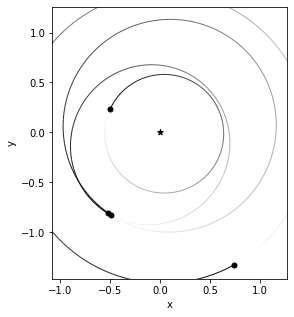

In [11]:
rebound.OrbitPlot(sa[-1])

For more information on the SimulationArchive, see https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchive.ipynb and https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchiveRestart.ipynb for more details.

# Going Further

The `NbodyRegressor` wrapper provides minimal functionality for easy comparisons to N-body integrations. If you want to go further you can always set integration parameters and run it yourself. 

For reference, all classes in SPOCK initialize simulation parameters with the `init_sim_parameters` function in spock/spock/simsetup.py. It:

* sets the timestep to 5% of the shortest pericenter passage time among all planets (Wisdom 2015)
* sets the integrator to WHFast (switches to IAS15 if e > 0.99, avoiding prohibitively short WHFast timestep)
* initializes MEGNO and sets collision detection
* overwrites any existing particle radii with their individual Hill radii for collision detection
* moves to the center-of-mass frame
* sets ri_whfast.safe_mode to 1

In particular, if you don't want to calculate the MEGNO and understand the consequences (https://github.com/hannorein/rebound/blob/master/ipython_examples/AdvWHFast.ipynb), you can skip `sim.init_megno()` and set `ri_whfast.safe_mode` to 0 to gain > a factor of two in computation time.

However, planetary systems are generally chaotic. If you do this (or change other parameters), you will not get the same chaotic realization of the trajectory as `FeatureClassifier` and `NbodyRegressor`. In principle this is not a problem, since each chaotic realization is equally valid, but it is something to keep in mind when wondering why one Nbody integration collides at 1e4 orbits and another at 5e4 (see Hussain & Tamayo 2019 for how instability times are typically distributed). 

We have tested in particular that the `FeatureClassifier` trained with a slightly different timestep than our N-body integrations (thus sampling different chaotic realizations) has the same performance as one trained using the exact same timestep and trajectories.